In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import ipywidgets as widgets
from ipywidgets import interact
import glob
from IPython.display import display
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


plt.style.use("seaborn-darkgrid")

# to get widgets to work in jupyter lab: jupyter labextension install @jupyter-widgets/jupyterlab-manager
# need to install nodejs as well

## Visualizing Fit Performance on the Master Line List
With the Fe lines, fit performance was assessed in a manual fashion. With more than double the lines for the master list, it's worthwhile to come up with a more elegant solution for assessing fit performance. It will still need to be manual, but rather than looping through all of the spectra, I'd like to try building a jupyter widget that plugs into our dataset and allows for more interactive inspection of the fit

In [23]:
# Widgets

file_loc = "../pydata/dupont_ph_ctrl/inputs/"
files = glob.glob(f"{file_loc}*wavsoln.fits")
files = [file.split("/")[-1]for file in files]

f_drop = widgets.Dropdown(
    options=files,
    value=files[0],
    description='File:',
    disabled=False,
)
line_list_df = pd.read_csv("master_line_list.csv")
line_list = [f'{species} {np.round(wav,3)}' for species, wav in zip(line_list_df['Species'],line_list_df['Wavelength'])]
l_drop = widgets.Dropdown(
    options=line_list,
    value='C I 5052.167',
    description='Line:',
    disabled=False,
)

mf_drop = widgets.Dropdown(
    options=['1','2','3'],
    value='1',
    description='Num. fits:',
    disabled=False,
)

left_reg = widgets.Text(
    value='0.3',
    placeholder='Type something',
    description=f'Left Region:',
    disabled=False
)

right_reg = widgets.Text(
    value='0.3',
    placeholder='Type something',
    description=f'Right Region:',
    disabled=False
)

fit_text = []
for i in range(3):
    fit_group = []
    fit_group.append(widgets.Text(
    value='-0.3',
    placeholder='Type something',
    description=f'Amp {i+1}:',
    disabled=False
))
    
    fit_group.append(widgets.Text(
    value='0',
    placeholder='Type something',
    description=f'Offset {i+1}:',
    disabled=False
))

    
    fit_group.append(widgets.Text(
    value='0.15',
    placeholder='Type something',
    description=f'Width {i+1}:',
    disabled=False
))
    fit_text.append(fit_group)

#display(f_drop, mf_drop)
#for group in fit_text:
#    display(*group)

def fitter(file, line, n_fits, left_reg, right_reg,fit1_a, fit1_o, fit1_w, fit2_a, fit2_o, fit2_w, fit3_a, fit3_o, fit3_w):
    s_hdu = fits.open(file_loc+file)
    fig = plt.figure(figsize=(10,6),dpi=125)
    left = float(left_reg)
    right = float(right_reg)

    line_cen = float(line.split(" ")[-1])
    width = 10
    lim_l = line_cen - width
    lim_r = line_cen + width
    
    
    s_data = s_hdu[1].data
    s_flux = s_data['FLUX']
    s_wav = s_data['WAVEL']
    
    wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
    s_flux = s_flux[wav_mask]
    s_wav = s_wav[wav_mask]
    yfit, norm, pts = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
    
    sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)
    sp.plotter(figure = fig, xmin=lim_l, xmax=lim_r, ymin=0, ymax=1.2)
    
    sp.baseline.basespec = np.ones(len(s_wav))
    n_fits = int(n_fits)

    if n_fits == 1:
        guesses = np.array([fit1_a, line_cen+float(fit1_o), fit1_w],dtype=float)
        print(f'{line}: ({width}, {left}, {right}, [{fit1_a}], [{fit1_o}], {fit1_w}, 0)')
    elif n_fits == 2:
        guesses = np.array([fit1_a, line_cen+float(fit1_o), fit1_w, 
                            fit2_a, line_cen+float(fit2_o), fit2_w])
        print(f'{line}: ({width}, {left}, {right}, [{fit1_a},{fit2_a}], [{fit1_o},{fit2_o}], {fit1_w}, 0)')
    elif n_fits == 3:
        guesses = np.array([fit1_a, line_cen+float(fit1_o), fit1_w, 
                            fit2_a, line_cen+float(fit2_o), fit2_w, 
                            fit3_a, line_cen+float(fit3_o), fit3_w])
        print(f'{line}: ({width}, {left}, {right}, [{fit1_a},{fit2_a},{fit3_a}], [{fit1_o},{fit2_o},{fit3_o}], {fit1_w}, 0)')
    #leg = plt.legend()
    #leg.set_draggable(True)
    # Something broke here when I updated dependencies, pyspeckit uses the deprecated .draggable attribute of plt.legend
    # I changed this in pyspeckit/spectrum/fitter at line 1370 to be the new value of .set_draggable instead
    sp.specfit(fittype='gaussian', guesses = guesses, exclude= [0,line_cen-left, line_cen+right, line_cen+5000], show_components=True)
    model = sp.specfit.get_model_frompars(s_wav, sp.specfit.parinfo)
    plt.plot(s_wav,model + 1)
    #plt.plot(s_wav,model1 + 1)
    EQW = sp.specfit.EQW(plot=False, continuum = 1.0, continuum_as_baseline=False,xmin=0, xmax = len(norm), components=True)
    print("EQW:", np.array(EQW)*1000*u.mA)
    plt.axhline(1, color = 'orange')
    plt.axvline(line_cen, color='r', alpha=0.5)
    plt.axvline(line_cen-float(left_reg), color='g', alpha=0.5)
    plt.axvline(line_cen+float(right_reg), color='g', alpha=0.5)
    #plt.plot(s_wav, yfit)
    #sp.plotter.savefig('basic_plot_example_withfit.png')
    

         
    
out = widgets.interactive_output(fitter,{'file': f_drop, 'line': l_drop, 'n_fits': mf_drop, 'left_reg': left_reg, 
                                         'right_reg': right_reg,
                                         'fit1_a':fit_text[0][0], 'fit1_o':fit_text[0][1], 'fit1_w':fit_text[0][2],
                                         'fit2_a':fit_text[1][0], 'fit2_o':fit_text[1][1], 'fit2_w':fit_text[1][2],
                                         'fit3_a':fit_text[2][0], 'fit3_o':fit_text[2][1], 'fit3_w':fit_text[2][2]})

option_hbox = widgets.HBox([f_drop, l_drop])
fit_param_hbox = widgets.HBox([mf_drop, left_reg, right_reg])
fit_hbox = widgets.HBox([widgets.VBox(group) for group in fit_text])
vbox = widgets.VBox([option_hbox,out,fit_param_hbox,fit_hbox])


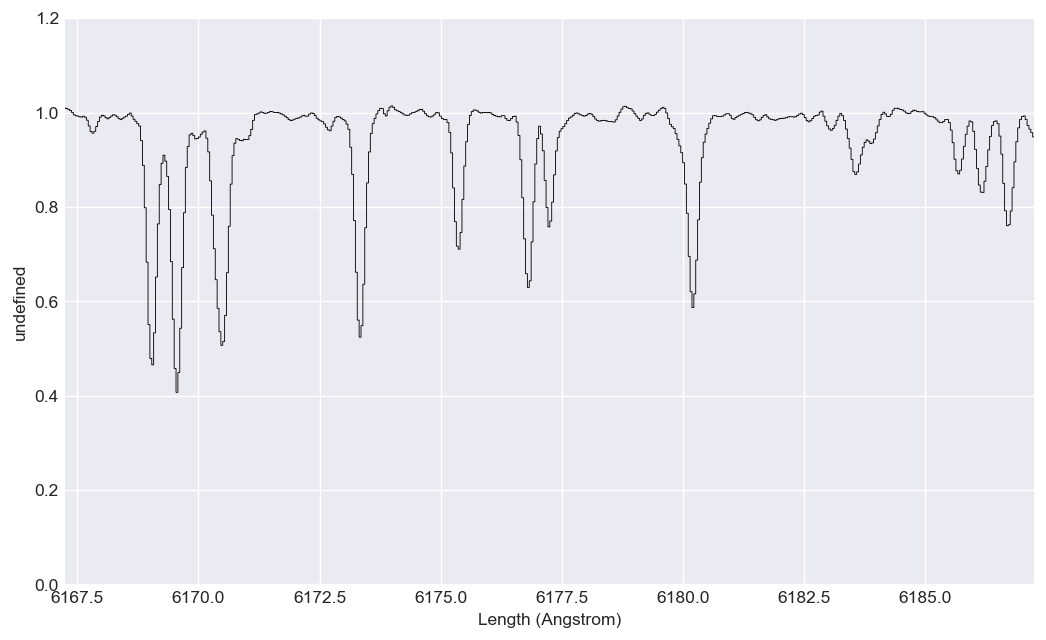

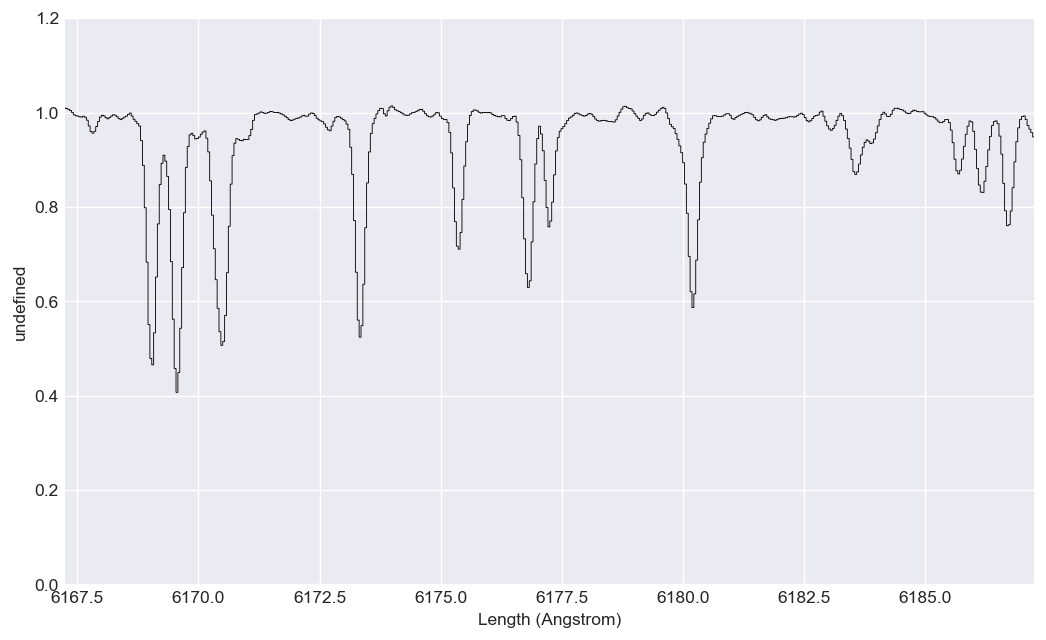

In [24]:
vbox

### Custom Line Profiles

- C I 5052.167: (10, 0.3, 0.15, [-0.15,-0.5], [0,-0.1], 0.15, 0)
- C I 5380.337: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0) Really weak ~10 mA
- C I 7111.47: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0) Really weak ~15 mA
- O I 6300.311: (10, 0.3, 0.4, [-0.3,-0.3], [0,0.25], 0.15, 0)
- Na I 5148.838: (10, 0.15, 0.35, [-0.3,-0.3], [0,0.25], 0.15, 0) Crowded
- Al I 6696.018: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0) Blended but double fit seems to mix up the lines
- Al I 8773.896: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) Blended, just fit core
- Al I 7835.309: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) winged profile, just fit core
- Si I 5645.611: (10, 0.3, 0.4, [-0.3,-0.1], [0,0.15], 0.15, 0)
- Si I 6125.021: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) nearby features, fit core
- Si I 6741.63: (10, 0.3, 0.35, [-0.3,-0.1], [0,0.15], 0.15, 0) blended, double fit
- Ca I 5512.98: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ca I 5590.114: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ca I 6439.08: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit, hyperfine?
- Ca I 6169.042: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit, companion
- Ca I 6499.65: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit, companion/hyperfine
- Ca I 5260.387: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ca I 6493.78: (10, 0.3, 0.5, [-0.3,-0.1], [0,0.4], 0.15, 0), blended, double fit
- Ca I 6471.662: (10, 0.6, 0.3, [-0.3,-0.2], [0,-0.4], 0.15, 0), blended, double fit
- Ca I 5581.965: (10, 0.3, 0.6, [-0.3,-0.2], [0,0.3], 0.15, 0)
- Sc I 5671.821: (10, 0.6, 0.15, [-0.3,-0.2], [0,-0.4], 0.15, 0)
- Sc I 5081.57: (10, 0.7, 0.4, [-0.3,-0.2,-0.3], [0,-0.4,0.2], 0.15, 0), triple fit
- Sc II 5657.87: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Sc II 6604.578: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Sc II 6320.843: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Sc II 6245.63: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Sc II 5684.19: (10, 0.3, 0.6, [-0.3,-0.3], [0,0.3], 0.15, 0) blended double fit
- Sc II 5526.82: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0) half core fit
- Sc II 6279.76: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) half core fit
- Ti I 5295.774: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Ti I 6258.104: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Ti I 5866.452: (10, 0.5, 0.3, [-0.3,-0.1], [0,-0.3], 0.15, 0) blended double fit
- Ti I 6554.22: (10, 0.6, 0.3, [-0.3,-0.1], [0,-0.3], 0.15, 0) blended double fit
- Ti I 6556.06: (10, 0.2, 0.2, [-0.3], [0], 0.15, 0) core fit
- Ti I 5219.7: (10, 0.3, 0.8, [-0.3,-0.3], [0,0.6], 0.15, 0) blended double fit
- Ti I 6126.217: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Ti I 5147.479: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Ti I 5113.448: (10, 0.6, 0.3, [-0.3,-0.3], [0,-0.2], 0.15, 0) blended double fit
- Ti I 5022.871: (10, 0.3, 0.9, [-0.3,-0.3,-0.3], [0,0.3,0.6], 0.15, 0) blended triple fit
- Ti I 4913.616: (10, 0.3, 0.6, [-0.3,-0.3], [0,0.3], 0.15, 0) blended double fit
- Ti I 5490.15: (10, 0.5, 0.3, [-0.3,-0.3], [0,-0.3], 0.15, 0) blended double fit
- Ti I 5739.464: (10, 0.6, 0.8, [-0.3,-0.3], [0,0.3], 0.15, 0) blended double fit
- Ti II 5336.778: (10, 0.45, 0.3, [-0.3,-0.3], [0,-0.4], 0.15, 0) blended double fit
- Ti II 5418.767: (10, 0.3, 0.7, [-0.3,-0.3], [0,0.4], 0.15, 0) blended double fit
- Ti II 5381.015: (10, 0.5, 0.3, [-0.3,-0.3], [0,-0.4], 0.15, 0) blended double fit
- Ti II 6606.97: (10, 0.3, 0.6, [-0.3,-0.3], [0,0.4], 0.15, 0) blended double fit
- Ti II 5211.54: (10, 0.5, 0.4, [-0.3,-0.3,-0.1], [0,-0.4,0.4], 0.15, 0) triple fit, kind of difficult
- Ti II 4911.193: (10, 0.3, 0.5, [-0.3,-0.3], [0,0.4], 0.15, 0) blended double fit
- Ti II 4874.014: (10, 0.5, 0.5, [-0.3,-0.3,-0.3], [0,-0.4,0.4], 0.15, 0) difficult triple fit
- Ti II 4865.611: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- V I 6251.82: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- V I 6357.292: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- V I 6531.415: (10, 0.6, 0.9, [-0.3,-0.1,-0.3], [0,-0.1,0.7], 0.15, 0) difficult triple fit
- V I 6785.008: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) hyperfine? core fit
- V I 6119.528: (10, 0.3, 0.4, [-0.3,-0.1], [0,0.2], 0.15, 0) double fit
- V I 6199.2: (10, 0.3, 0.5, [-0.3,-0.1], [0,0.3], 0.15, 0) double fit
- V I 6090.21: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- V I 6039.73: (10, 0.8, 0.5, [-0.3,-0.1,-0.3], [0,0.3,-0.4], 0.15, 0) might even need a quadruple fit
- V I 6081.44: (10, 0.15, 0.6, [-0.3,-0.1], [0,0.3], 0.15, 0) double fit, core fit on left
- V I 4875.486: (10, 0.15, 0.6, [-0.3,-0.1], [0,0.3], 0.15, 0) double fit
- V I 5670.85: (10, 0.6, 0.15, [-0.3,-0.1], [0,-0.4], 0.15, 0) double fit, weak line blended right as well?
- V I 5727.046: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) core fit
- Cr I 4936.335: (10, 0.15, 0.5, [-0.3,-0.3], [0,0.3], 0.15, 0) double fit
- Cr I 5214.14: (10, 0.6, 0.2, [-0.3,-0.3], [0,-0.3], 0.15, 0) double fit
- Cr I 6661.08: (10, 0.3, 0.4, [-0.3,-0.3], [0,0.2], 0.15, 0) double fit
- Cr I 5238.964: (10, 0.6, 0.5, [-0.3,-0.1,-0.3], [0,0.3,-0.4], 0.15, 0) triple fit
- Cr I 5247.566: (10, 0.7, 0.6, [-0.3,-0.1,-0.3], [0,0.3,-0.4], 0.15, 0) complex triple fit
- Cr I 5272.007: (10, 0.2, 0.6, [-0.3,-0.1], [0,0.3], 0.15, 0) double fit
- Cr I 5287.2: (10, 0.35, 0.7, [-0.3,-0.1], [0,0.3], 0.15, 0) double fit
- Cr I 5296.691: (10, 0.15, 0.15, [-0.3,-0.1], [0,0.3], 0.15, 0) core fit
- Cr I 5348.312: (10, 0.5, 0.3, [-0.3,-0.1], [0,-0.2], 0.15, 0) double fit
- Cr I 5300.744: (10, 0.3, 0.5, [-0.3,-0.1], [0,0.4], 0.15, 0) double fit
- Cr I 5783.87: (10, 0.15, 0.3, [-0.3], [0], 0.15, 0) core fit on right
- Cr I 5783.08: (10, 0.15, 0.3, [-0.3], [0], 0.15, 0) core fit on right
- Cr II 5237.328: (10, 0.4, 0.3, [-0.3,-0.1], [0,-0.3], 0.15, 0)
- Cr II 5246.767: (10, 0.4, 0.5, [-0.3,-0.1], [-0.1,0.3], 0.15, 0) line cen a bit offset
- Cr II 5502.067: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0) hard to double fit, core fit instead, may be overestimated
- Cr II 5305.87: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Cr II 5308.41: (10, 0.3, 0.4, [-0.3,-0.3], [0,0.3], 0.15, 0)
- Mn I 6016.64: (10, 0.3, 0.65, [-0.3,-0.3], [0,0.4], 0.15, 0)
- Mn I 6013.49: (10, 0.6, 0.65, [-0.3,-0.3,-0.3], [0,0.4,-0.3], 0.15, 0)
- Mn I 5004.891: (10, 0.3, 0.4, [-0.1,-0.2], [0,0.4], 0.15, 0) hard to fit
- Co I 5212.691: (10, 0.7, 0.5, [-0.3,-0.2,-0.3], [0,-0.5,0.3], 0.15, 0)
- Co I 6814.942: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Co I 5247.911: (10, 0.55, 0.15, [-0.3,-0.3], [0,-0.4], 0.15, 0)
- Co I 5301.039: (10, 0.5, 0.15, [-0.3,-0.3], [0,-0.4], 0.15, 0)
- Co I 5483.352: (10, 0.5, 0.3, [-0.3,-0.3], [0,-0.4], 0.15, 0)
- Co I 5530.774: (10, 0.5, 0.3, [-0.3,-0.3], [0,-0.4], 0.15, 0)
- Co I 5342.695: (10, 0.3, 0.4, [-0.3,-0.3], [0,0.3], 0.15, 0)
- Co I 6189.0: (10, 0.3, 0.5, [-0.3,-0.3], [0,0.3], 0.15, 0)
- Ni I 6223.984: (10, 0.3, 0.3, [-0.3], [0], 0.15, 0)
- Ni I 5176.56: (10, 0.3, 0.5, [-0.3,-0.3], [0,0.3], 0.15, 0) line is having some cfitsio troubles?
- Ni I 6643.63: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 6176.811: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 5643.078: (10, 0.6, 0.5, [-0.3,-0.3,-0.3], [0,0.3,-0.5], 0.15, 0)
- Ni I 6130.135: (10, 0.8, 0.5, [-0.3,-0.3,-0.3], [0,0.3,-0.5], 0.15, 0)
- Ni I 6204.604: (10, 0.3, 0.8, [-0.3,-0.3], [0,0.6], 0.15, 0)
- Ni I 6586.33: (10, 0.3, 0.5, [-0.3,-0.1], [0,0.4], 0.15, 0)
- Ni I 6532.89: (10, 0.7, 0.3, [-0.3,-0.1], [0,-0.5], 0.15, 0) may be two lines on top of eachother
- Ni I 7727.624: (10, 0.3, 0.8, [-0.3,-0.1], [0,0.6], 0.15, 0) hard blend to fit
- Ni I 5589.358: (10, 0.2, 0.3, [-0.3], [0], 0.15, 0), core fit right
- Ni I 6086.282: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 6772.315: (10, 0.3, 0.2, [-0.3], [0], 0.15, 0)
- Ni I 6378.25: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 6108.116: (10, 0.15, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 6327.6: (10, 0.3, 0.3, [-0.3], [0], 0.15, 0)
- Ni I 6767.772: (10, 0.3, 0.15, [-0.3], [0], 0.15, 0)
- Ni I 5010.938: (10, 0.3, 0.4, [-0.3,-0.1], [0,0.3], 0.15, 0)






### Checked Lines

C I 5052.167, C I 5380.337, C I 7111.47, C I 7113.179, O I 6300.311, O I 7775.388, O I 7774.166, O I 7771.944, Na I 6160.747, Na I 6154.225, Mg I 6319.236, Mg I 5711.088, Al I 6696.018, Al I 8773.896, Al I 6698.667, Al I 7835.309, Al I 7835.309, Al I 8772.866 (hyperfine example?), Al I 7836.134, Si I 5793.073, Si I 6244.476, Si I 5488.983, Si I 5645.611, Si I 5665.554, Si I 6721.848, Si I 6125.021, Si I 6741.63, S I 6757.153, S I 8693.93, S I 8694.62, S I 6046.0, K I 7698.974, Ca I 5512.98, Ca I 5590.114, Ca I 6166.439, Ca I 6455.598, Ca I 5867.562, Ca I 6439.08, Ca I 6169.042, Ca I 6508.84, Ca I 5260.387, Ca I 6161.3, Ca I 6493.78, Ca I 6471.662, Ca I 5581.965, Sc I 5671.821, Sc I 5081.57, Sc I 5520.497, Sc II 5657.87, Sc II 6604.578, Sc II 6320.843, Sc II 6245.63, Sc II 5684.19, Sc II 5526.82, Sc II 6279.76, Ti I 5295.774, Ti I 6258.104, Ti I 6261.101, Ti I 6091.174, Ti I 5866.452, Ti I 6556.06, Ti I 6599.11, Ti I 6126.217, Ti I 5147.479, Ti I 5113.448, Ti I 5022.871, Ti I 4913.616, Ti I 5490.15, Ti I 5739.464, Ti II 5336.778, Ti II 5418.767, Ti II 5381.015, Ti II 6606.97, Ti II 5211.54, Ti II 4911.193, Ti II 4865.611, V I 6251.82, V I 6357.292, V I 6531.415, V I 6785.008, V I 6119.528, V I 6199.2, V I 6090.21, V I 6039.73, V I 6081.44, V I 4875.486, V I 5670.85, V I 5727.046, Cr I 4936.335,Cr I 5214.14,Cr I 6661.08,Cr I 5238.964,Cr I 5247.566,Cr I 5272.007,Cr I 5287.2,Cr I 5296.691, Cr I 5345.801, Cr I 5348.312, Cr I 5300.744, Cr I 5783.87, Cr I 5783.08, Cr II 5237.328, Cr II 5246.767, Cr II 5502.067, Cr II 5305.87, Cr II 5308.41, Mn I 6016.64, Mn I 6013.49, Mn I 5004.891, Mn I 6021.79, Mn I 5399.47, Co I 5212.691, Co I 6814.942, Co I 5247.911, Co I 5301.039, Co I 6454.995, Co I 5647.23, Co I 5483.352, Co I 5530.774, Co I 5342.695, Co I 6189.0, Ni I 6223.984, Ni I 5176.56, Ni I 6643.63, Ni I 6176.811, Ni I 5643.078,Ni I 6130.135,Ni I 6204.604,Ni I 6586.33, Ni I 6532.89, Ni I 7727.624, Ni I 5589.358, Ni I 4953.208, Ni I 7797.586, Ni I 6086.282, Ni I 6772.315, Ni I 6378.25, Ni I 5805.217, Ni I 6108.116, Ni I 6327.6, Ni I 6767.772, Ni I 5010.938

### Throw out candidates
- C I 6587.61 - Too weak
- O I 6156.76 - Too weak
- Na I 5148.838 - Crowded
- Mg I 6319.236 - Too closely blended? Hyperfine splitting?
- Al I 7835.309, near a massive drop off in throughput?
- S I 6757.153 - Too weak
- S I 8693.93 - Local continuum messy?
- S I 8694.62 - ^
- S I 6052.656 - Too weak
- Ti II 5211.54 - kind of a difficult triple fit for an element that we have a lot of good measurements for
- Ti II 4874.014 - difficult triple fit again
- V I 6785.008 - hyperfine, difficult to fit
- V I 6039.73 - might need a quadruple fit, we have other good V measurement
- V I 6081.44 - complex fit
- Cr I 5247.566 - complex triple fit
- Cr I 5345.801 - hyperfine, not a good fit
- Cr II 5502.067
- Mn I 5004.891 - hard to fit
- Ni I 6532.89 - possibly two lines on top of eachother, or hyperfine splitting
- Ni I 7727.624 - hard blend to fit

In [ ]:
#checkbox for solar spectrum overlay 
#O I 6300 nickel blend overtop
# triangle profile indicates hyperfine splitting
# stronger lines start to break down on local thermodynamic equilibrium; shape can get funny
# telluric lines can be shown by only being visible in a single cluster
# use dupont or M67 (BD)
# make a plot of how many lines of each element we have